# Ciencia de datos aplicada (ITBA): Tercer Entregable

**Predicción de nuevos datos utilizando el mejor modelo entrenado**

**Equipo:** Gaston Francois - Nicolas Suarez Durrels - Franco Rupnik

**Nombre del proyecto**: Prophetario

V4 utiliza todos los datos menos los que no tengan lat y lon. Tambien esta utilizando las nuevas columnas de localizacion.


In [32]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import lightgbm as lgb

sns.set_theme(style="whitegrid")

In [33]:
df = pd.read_csv("dataset_geo_added_v2.csv")
print("Shape del dataset antes:", df.shape)

# Filter out rows where original coordinates are null
df = df.dropna(subset=['original_lat', 'original_lon'])

# Drop the original coordinate columns
df = df.drop(columns=['original_lat', 'original_lon'])


print("Shape del dataset:", df.shape)
df.head()

Shape del dataset antes: (809, 21)
Shape del dataset: (745, 19)


,Cantidad_plantas,antiguedad,dormitorios,cocheras,baños,ambientes,m2_totales,m2_cubiertos,expenses,price,latitud,longitud,nearby_avg_price_m2,precio_m2_barrio,precio_m2_cercano,Pileta_sí,Apto_credito_sí,vivienda_Departamento,vivienda_PH
0,-0.117407,-0.135918,1.289863,-0.050272,1.121699,0.792867,0.516783,1.969679,-0.715738,13.287880,-0.088921,0.184388,1686.567164,-0.563223,0.088835,0.0,0.0,0.0,0.0
1,-0.117407,1.071301,0.331645,-0.050272,-1.003487,0.143647,-0.785713,-0.728626,0.411538,11.931642,-0.105621,0.208896,NaN,0.833456,0.791214,0.0,0.0,1.0,0.0
2,8.517362,-0.890430,0.331645,-0.050272,1.121699,0.143647,3.371502,0.932830,1.936677,12.847929,-0.079613,0.157092,415.036630,-0.563223,-1.633849,1.0,0.0,0.0,0.0
3,-0.117407,-0.940731,2.248080,0.309643,5.372073,2.091308,1.212101,3.556183,-0.715738,13.038767,-0.016330,-0.864337,1257.227049,-0.563223,-0.233340,0.0,0.0,0.0,0.0
4,-0.117407,1.574310,0.331645,-0.050272,0.059106,0.143647,-0.462538,0.145825,0.942021,12.100718,0.452603,-0.899854,719.496229,0.833456,-1.221364,0.0,0.0,1.0,0.0


In [34]:
X = df.drop(columns=["price", "nearby_avg_price_m2"])
y = df["price"]

In [35]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [36]:
model = LinearRegression()
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

print(f"MAE: {mae:.2f}")
print(f"MSE: {mse:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"R^2: {r2:.2f}")

MAE: 0.28
MSE: 0.17
RMSE: 0.41
R^2: 0.45


## Evaluación del modelo de Regresión Lineal

## Visualización: Precio real vs. predicho

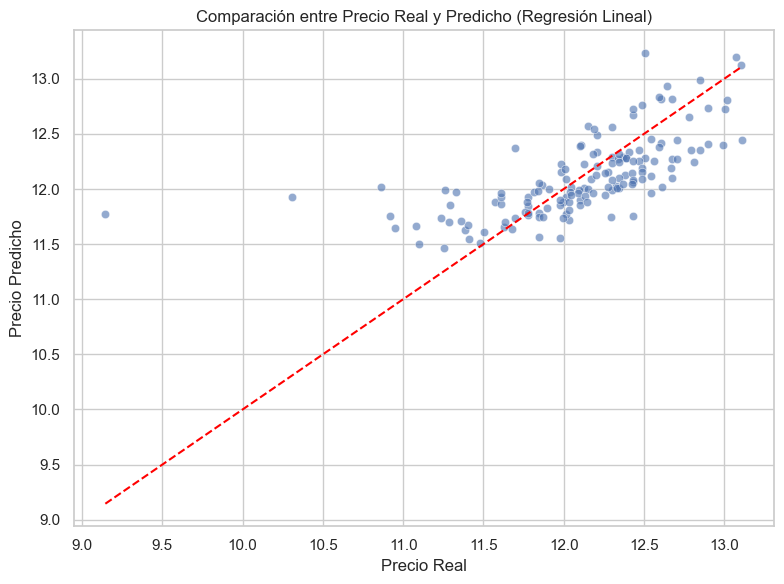

In [37]:
plt.figure(figsize=(8, 6))
sns.scatterplot(x=y_test, y=y_pred, alpha=0.6)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color='red', linestyle='--')
plt.xlabel("Precio Real")
plt.ylabel("Precio Predicho")
plt.title("Comparación entre Precio Real y Predicho (Regresión Lineal)")
plt.tight_layout()
plt.show()

## Comparativa con Random Forest

In [38]:
rf_model = RandomForestRegressor(random_state=42)
rf_model.fit(X_train, y_train)
y_rf_pred = rf_model.predict(X_test)

mae_rf = mean_absolute_error(y_test, y_rf_pred)
mse_rf = mean_squared_error(y_test, y_rf_pred)
rmse_rf = np.sqrt(mse_rf)
r2_rf = r2_score(y_test, y_rf_pred)

print(f"Random Forest MAE: {mae_rf:.2f}")
print(f"Random Forest MSE: {mse_rf:.2f}")
print(f"Random Forest RMSE: {rmse_rf:.2f}")
print(f"Random Forest R^2: {r2_rf:.2f}")

Random Forest MAE: 0.25
Random Forest MSE: 0.23
Random Forest RMSE: 0.48
Random Forest R^2: 0.25


## Comparativa con LightGBM


In [39]:

# ## Comparativa con LightGBM
lgb_model = lgb.LGBMRegressor(random_state=29, verbose=-1)
callbacks = [
    lgb.early_stopping(stopping_rounds=10, verbose=False),
    lgb.log_evaluation(period=0)
]

lgb_model.fit(
    X_train, y_train,
    eval_set=[(X_train, y_train), (X_test, y_test)],
    eval_names=['train', 'valid'],
    eval_metric='l1',
    callbacks=callbacks
)

y_lgb_pred = lgb_model.predict(X_test)

mae_lgb = mean_absolute_error(y_test, y_lgb_pred)
mse_lgb = mean_squared_error(np.expm1(y_test), np.expm1(y_lgb_pred))
rmse_lgb = np.sqrt(mse_lgb)
r2_lgb = r2_score(y_test, y_lgb_pred)

print(f"LightGBM MAE: {mae_lgb:.2f}")
print(f"LightGBM MSE: {mse_lgb:.2f}")
print(f"LightGBM RMSE: {rmse_lgb:.2f}")
print(f"LightGBM R^2: {r2_lgb:.2f}")


LightGBM MAE: 0.21
LightGBM MSE: 2869307817.43
LightGBM RMSE: 53565.92
LightGBM R^2: 0.60


## Comparación visual de modelos

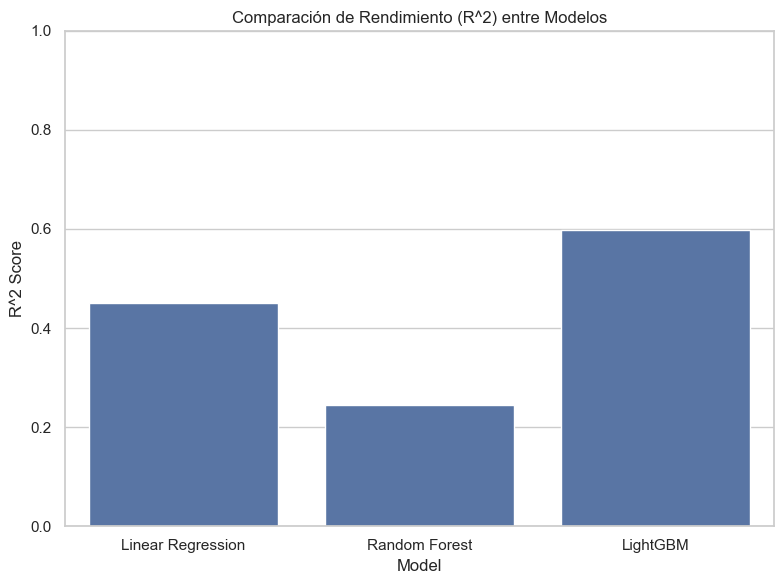

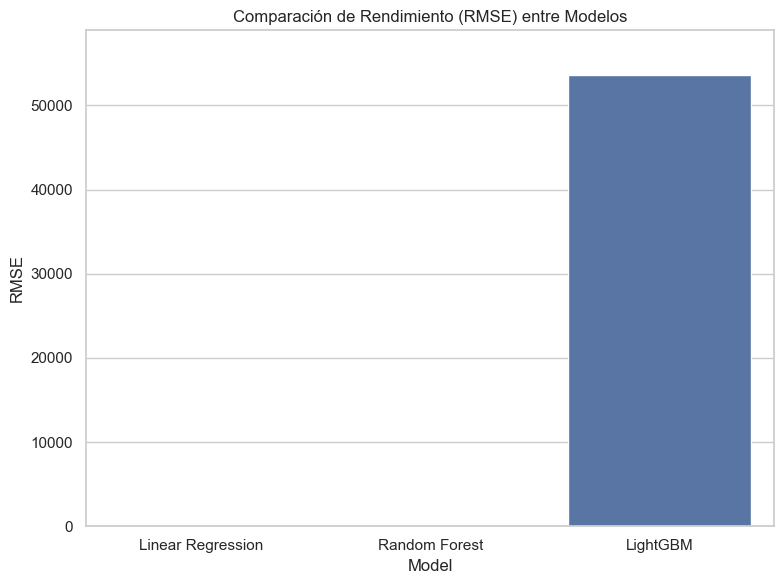

In [40]:
results = pd.DataFrame({'Model': ['Linear Regression', 'Random Forest', 'LightGBM'],
                        'R^2': [r2, r2_rf, r2_lgb]})

plt.figure(figsize=(8, 6))
sns.barplot(x='Model', y='R^2', data=results)
plt.ylabel("R^2 Score")
plt.title("Comparación de Rendimiento (R^2) entre Modelos")
plt.ylim(0, 1)
plt.tight_layout()
plt.show()

#Now with RMSE
results_rmse = pd.DataFrame({'Model': ['Linear Regression', 'Random Forest', 'LightGBM'],
                              'RMSE': [rmse, rmse_rf, rmse_lgb]})
plt.figure(figsize=(8, 6))
sns.barplot(x='Model', y='RMSE', data=results_rmse)
plt.ylabel("RMSE")
plt.title("Comparación de Rendimiento (RMSE) entre Modelos")
plt.ylim(0, results_rmse['RMSE'].max() * 1.1)
plt.tight_layout()
plt.show()

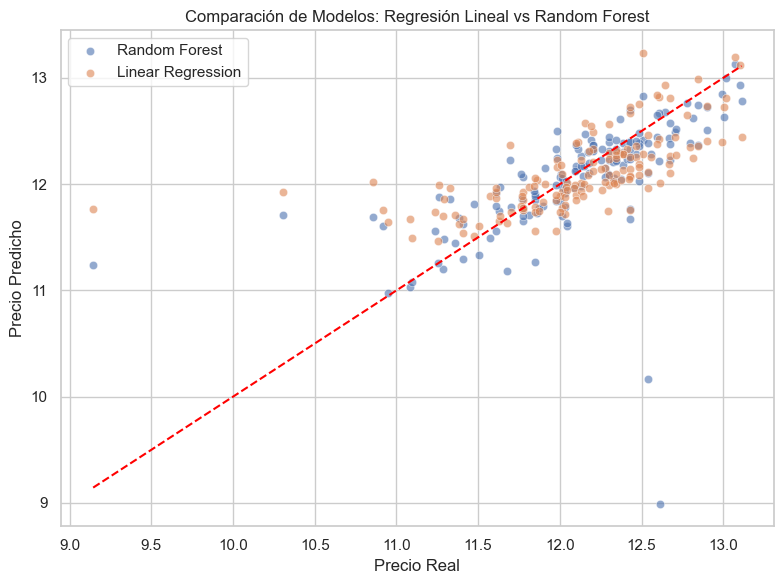

In [41]:
plt.figure(figsize=(8, 6))
sns.scatterplot(x=y_test, y=y_rf_pred, alpha=0.6, label="Random Forest")
sns.scatterplot(x=y_test, y=y_pred, alpha=0.6, label="Linear Regression")
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color='red', linestyle='--')
plt.xlabel("Precio Real")
plt.ylabel("Precio Predicho")
plt.title("Comparación de Modelos: Regresión Lineal vs Random Forest")
plt.legend()
plt.tight_layout()
plt.show()

In [42]:
import numpy as np
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from lightgbm import LGBMRegressor
from sklearn.metrics import mean_squared_error, r2_score, root_mean_squared_error  # Updated import

### 1. Random Forest Tuning
rf = RandomForestRegressor(random_state=42)
rf_params = {
    'n_estimators': [100, 200, 50, 25, 10],
    'max_depth': [None, 10, 20, 30, 5, 2, 7],
    'min_samples_split': [2, 5],
}

rf_grid = GridSearchCV(rf, rf_params, cv=3, scoring='neg_mean_squared_error', n_jobs=-1)
rf_grid.fit(X_train, y_train)

best_rf = rf_grid.best_estimator_
rf_preds_log = best_rf.predict(X_test)
rf_preds = np.expm1(rf_preds_log)
y_test_orig = np.expm1(y_test)

print("Random Forest:")
print("Best Params:", rf_grid.best_params_)
print("RMSE:", root_mean_squared_error(y_test_orig, rf_preds))  # Updated to use root_mean_squared_error
print("R²:", r2_score(y_test_orig, rf_preds))

### 2. LightGBM Tuning
lgbm = LGBMRegressor(random_state=42)
lgbm_params = {
    'n_estimators': [100, 200, 50, 25, 10],
    'max_depth': [-1, 10, 20, 30, 5, 15],
    'learning_rate': [0.1, 0.05, 0.01, 0.005],
    'num_leaves': [31, 50, 10, 15, 20],
}

lgbm_grid = GridSearchCV(lgbm, lgbm_params, cv=3, scoring='neg_mean_squared_error', n_jobs=-1)
lgbm_grid.fit(X_train, y_train)

best_lgbm = lgbm_grid.best_estimator_
lgbm_preds_log = best_lgbm.predict(X_test)
lgbm_preds = np.expm1(lgbm_preds_log)

print("\nLightGBM:")
print("Best Params:", lgbm_grid.best_params_)
print("RMSE:", root_mean_squared_error(y_test_orig, lgbm_preds))  # Updated to use root_mean_squared_error
print("R²:", r2_score(y_test_orig, lgbm_preds))


Random Forest:
Best Params: {'max_depth': 20, 'min_samples_split': 5, 'n_estimators': 100}
RMSE: 58282.35539560142
R²: 0.6313866941623767

LightGBM:
Best Params: {'learning_rate': 0.1, 'max_depth': -1, 'n_estimators': 50, 'num_leaves': 10}
RMSE: 55643.67446467606
R²: 0.6640083994564003


C:\Users\nicos\OneDrive\Desktop\Facultad\datos\TP-73.84-ZonaProp\.venv\Lib\site-packages\numpy\ma\core.py:2892: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


In [43]:
#Dump the best random forest model
import joblib
joblib.dump(rf_model, 'best_random_forest_model.joblib')
joblib.dump(best_lgbm, 'best_lightgbm_model.joblib')

['best_lightgbm_model.joblib']

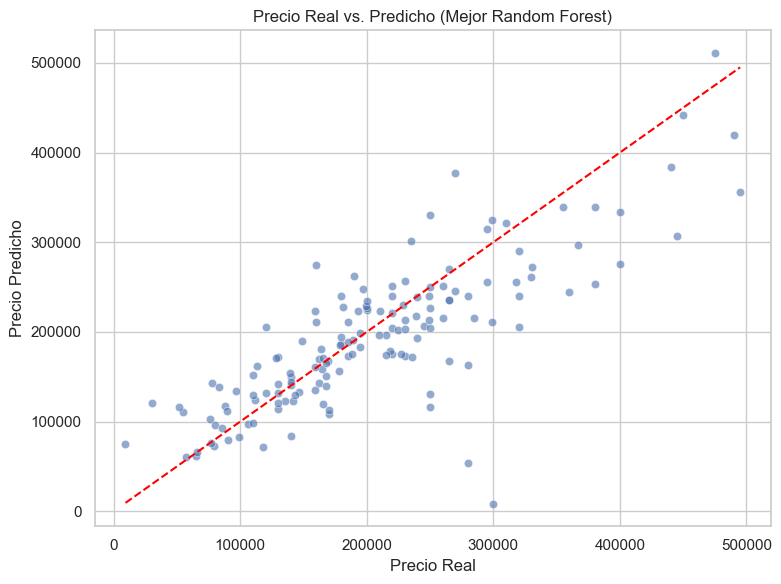

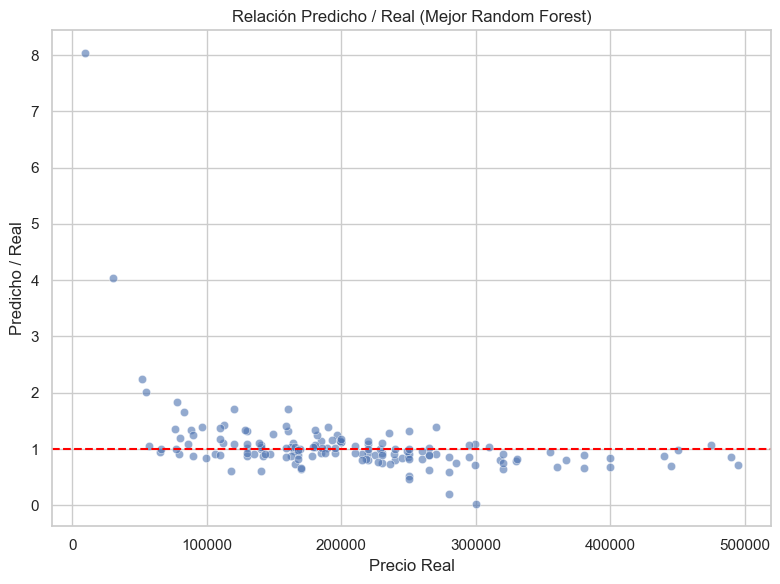

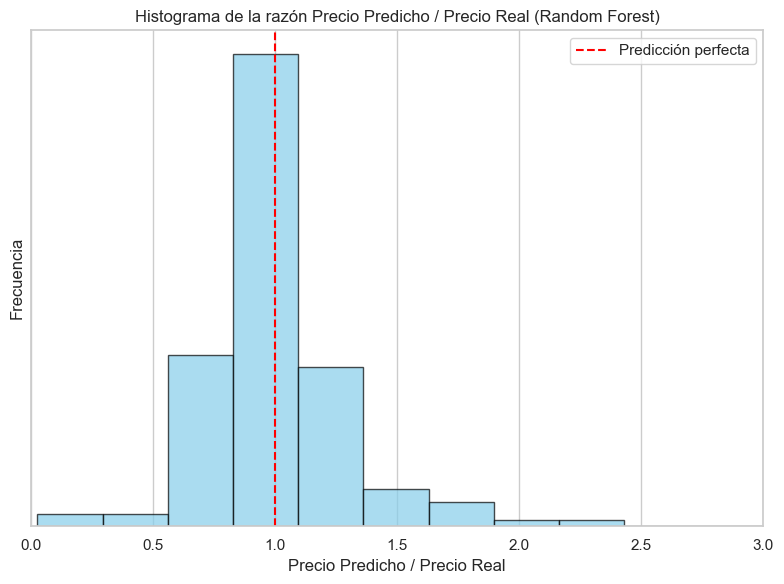

In [44]:

plt.figure(figsize=(8, 6))
sns.scatterplot(x=y_test_orig, y=rf_preds, alpha=0.6)
plt.plot([y_test_orig.min(), y_test_orig.max()], [y_test_orig.min(), y_test_orig.max()], color='red', linestyle='--')
plt.xlabel("Precio Real")
plt.ylabel("Precio Predicho")
plt.title("Precio Real vs. Predicho (Mejor Random Forest)")
plt.tight_layout()
plt.show()


plt.figure(figsize=(8, 6))
sns.scatterplot(x=y_test_orig, y=rf_preds / y_test_orig, alpha=0.6)
plt.axhline(y=1, color='red', linestyle='--')
plt.xlabel("Precio Real")
plt.ylabel("Predicho / Real")
plt.title("Relación Predicho / Real (Mejor Random Forest)")
plt.tight_layout()
plt.show()


plt.figure(figsize=(8, 6))
plt.hist(rf_preds / y_test_orig, bins=30, color='skyblue', edgecolor='black', alpha=0.7)
plt.axvline(x=1, color='red', linestyle='--', label='Predicción perfecta')
plt.xlabel('Precio Predicho / Precio Real')
plt.ylabel('Frecuencia')
plt.title('Histograma de la razón Precio Predicho / Precio Real (Random Forest)')
plt.xlim(0, 3)
plt.yticks([])
plt.legend()
plt.tight_layout()
plt.show()




La línea roja en el gráfico representa la línea de predicción perfecta, es decir, donde el precio predicho sería exactamente igual al precio real. Sirve como referencia visual: cuanto más cerca estén los puntos de esa línea, mejor es el desempeño del modelo.

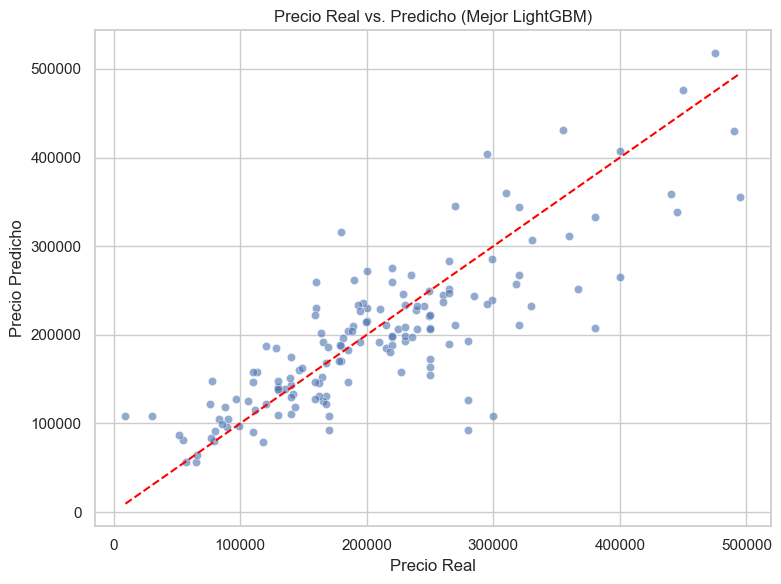

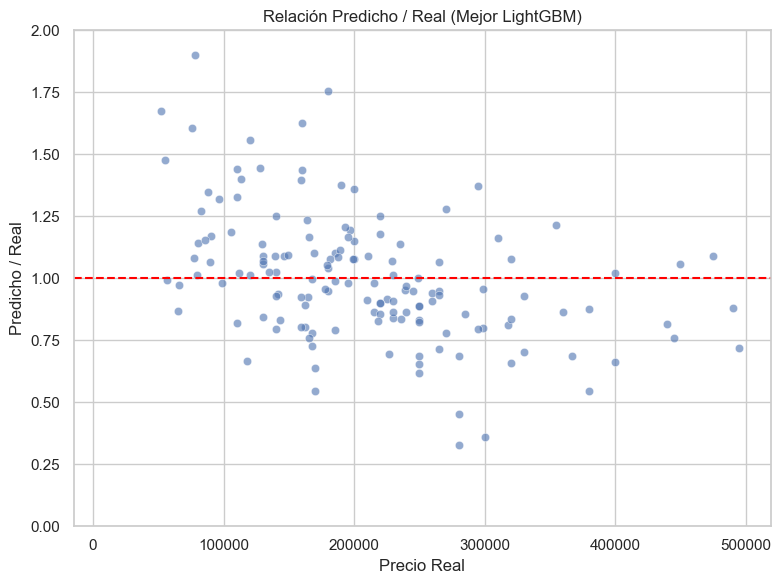

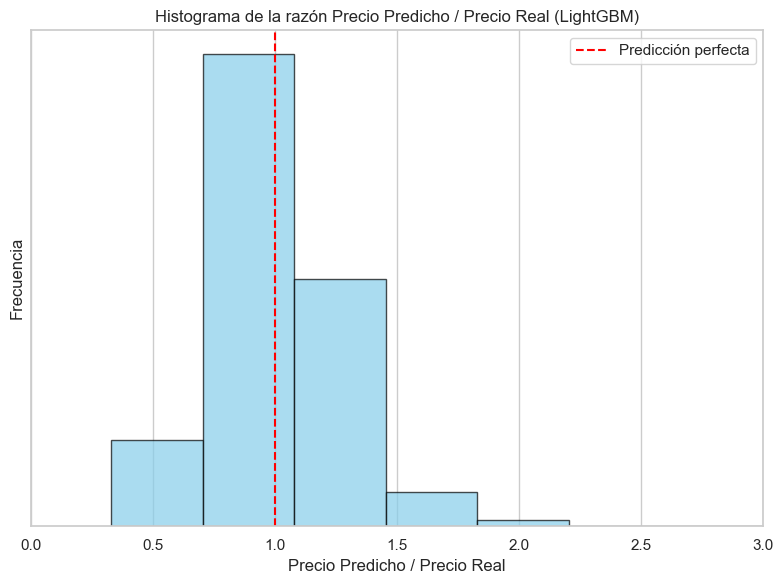

In [45]:
# Second cell - Visualizations for LightGBM
plt.figure(figsize=(8, 6))
sns.scatterplot(x=y_test_orig, y=lgbm_preds, alpha=0.6)
plt.plot([y_test_orig.min(), y_test_orig.max()], [y_test_orig.min(), y_test_orig.max()], color='red', linestyle='--')
plt.xlabel("Precio Real")
plt.ylabel("Precio Predicho")
plt.title("Precio Real vs. Predicho (Mejor LightGBM)")
plt.tight_layout()
plt.show()

plt.figure(figsize=(8, 6))
sns.scatterplot(x=y_test_orig, y=lgbm_preds / y_test_orig, alpha=0.6)
plt.axhline(y=1, color='red', linestyle='--')
plt.xlabel("Precio Real")
plt.ylabel("Predicho / Real")
plt.title("Relación Predicho / Real (Mejor LightGBM)")
plt.ylim(0, 2)  # Set y-axis limit to 2
plt.tight_layout()
plt.show()

plt.figure(figsize=(8, 6))
plt.hist(lgbm_preds / y_test_orig, bins=30, color='skyblue', edgecolor='black', alpha=0.7)
plt.axvline(x=1, color='red', linestyle='--', label='Predicción perfecta')
plt.xlabel('Precio Predicho / Precio Real')
plt.ylabel('Frecuencia')
plt.title('Histograma de la razón Precio Predicho / Precio Real (LightGBM)')
plt.xlim(0, 3)
plt.yticks([])
plt.legend()
plt.tight_layout()
plt.show()

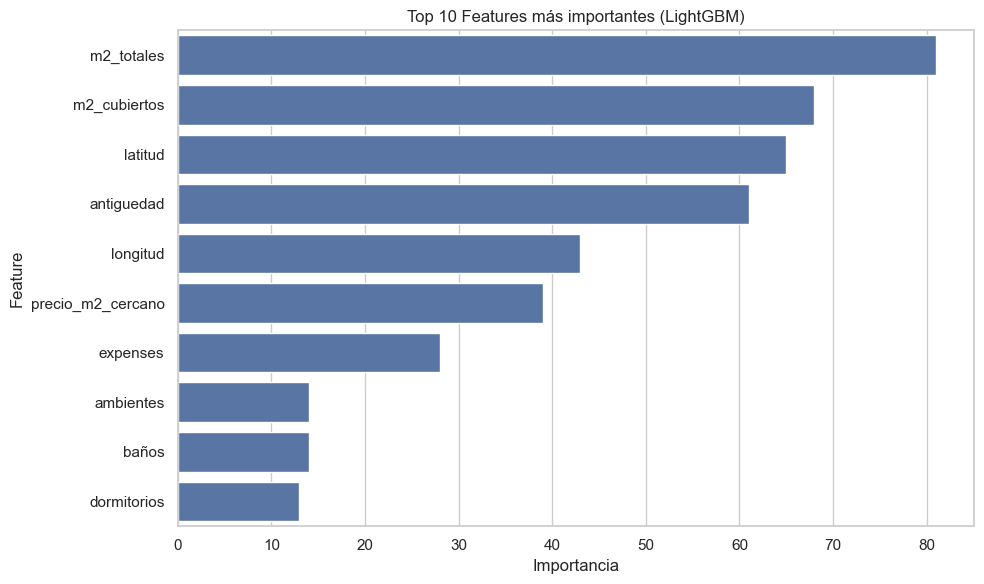

In [46]:
# Third cell - Feature importance for LightGBM
feature_importance = pd.DataFrame({
    'feature': X.columns,
    'importance': best_lgbm.feature_importances_
})
feature_importance = feature_importance.sort_values('importance', ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(x='importance', y='feature', data=feature_importance.head(10))
plt.title('Top 10 Features más importantes (LightGBM)')
plt.xlabel('Importancia')
plt.ylabel('Feature')
plt.tight_layout()
plt.show()